In [ ]:
import numpy as np
import gc
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def generate_random_dot_image(width, height, min_dots, max_dots, dot_size):
  num_dots = np.random.randint(min_dots, max_dots + 1)

  # Creates an array of the given shape filled with zeros (black)
  black_image = np.zeros((height, width), dtype=np.uint8)

  # Generate arrays of random x and y coordinates for the top-left corner of each dot
  random_x = np.random.randint(0, width - dot_size + 1, num_dots)
  random_y = np.random.randint(0, height - dot_size + 1, num_dots)

  # Iterates over each pair of (x, y) coordinates. For each dot, it sets a square region of the image (dot_size) to the pixel value 155
  # 155 corresponds to a mid-range gray on a scale of 0 (black) to 255 (white), so each dot will appear gray against the black background
  for x, y in zip(random_x, random_y):
    black_image[y:y + dot_size, x:x + dot_size] = 215

  # print(f"\nblack_image: {black_image}")

  return black_image

In [ ]:
def generate_random_dot_image_with_gaussian_distribution(width, height, min_dots, max_dots, dot_size):
  num_dots = np.random.randint(min_dots, max_dots + 1)

  # Creates an array of the given shape filled with zeros (black)
  black_image = np.zeros((height, width), dtype=np.uint8)

  # Generate arrays of random x and y coordinates for the top-left corner of each dot
  random_x = np.random.randint(0, width - dot_size + 1, num_dots)
  random_y = np.random.randint(0, height - dot_size + 1, num_dots)

  # Define the mean and standard deviation for the normal distribution
  mean_value = 128
  # Assuming we want a reasonable spread that fits the mode at the middle of the range
  std_deviation = (215 - 40) / 6  # This is a rough estimation to cover 99.7% (3-sigma)

  # Iterates over each pair of (x, y) coordinates. For each dot, it sets a square region of the image (dot_size) to the pixel value 155
  # 155 corresponds to a mid-range gray on a scale of 0 (black) to 255 (white), so each dot will appear gray against the black background
  for x, y in zip(random_x, random_y):
     # Generate normally distributed random values with clipping to enforce range
     dot_values = np.random.normal(mean_value, std_deviation, (dot_size, dot_size))
     dot_values_clipped = np.clip(dot_values, 40, 215).astype(np.uint8)

     # Set the pixel values in the black image for each dot
     black_image[y:y + dot_size, x:x + dot_size] = dot_values_clipped

  # print(f"\nblack_image: {black_image}") print distribution is it possible

  return black_image

In [ ]:
def generate_random_rings_image(width, height, min_rings, max_rings, thicc):
    white_image = np.full((height, width), 255, dtype=np.uint8)  # White background

    center_x, center_y = width // 2, height // 2  # Center of the image

    # Randomly chooses the number of rings to generate
    num_rings = np.random.randint(min_rings, max_rings + 1)

    # Generates random radii for each ring, constrained between 1/20th and 1/3rd of the smaller dimension of the image, ensuring that rings fit within the image frame
    # radii = np.random.randint(min(width, height) // 20, min(width, height) // 3, size=num_rings)
    # It's OK to go slightly over the image frame based on real image analysis (change range to 1/20 and 1/1.8)
    radii = np.random.randint(min(width, height) // 20, min(width, height) // 1.8, size=num_rings)

    # Sorts and then reverses the list of radii, so rings are drawn from the largest to the smallest. This ensures that smaller rings are not obscured by larger ones when drawn
    radii.sort()  # Sort radii in ascending order
    radii = radii[::-1]  # Reverse to start drawing from largest to smallest

    # Iterates over each radius, calculating the outer_radius and inner_radius of each ring. The inner radius is adjusted by the thicc parameter to create the thickness of the ring
    for radius in radii:
        outer_radius = radius
        inner_radius = max(outer_radius - thicc, 0)  # Ensure non-negative radius

        # Computes boolean masks for the outer and inner boundaries of each ring
        # The outer mask is where the circle pixels will be black, and the inner mask is where the circle pixels revert to white, forming the hollow part of each ring
        # Uses the masks to set the appropriate pixels in white_image. The outer ring area is set to black (0), and the inner ring area is set back to white (255), effectively drawing hollow rings
        y_indices, x_indices = np.ogrid[:height, :width]
        mask_outer = (x_indices - center_x)**2 + (y_indices - center_y)**2 <= outer_radius**2
        mask_inner = (x_indices - center_x)**2 + (y_indices - center_y)**2 < inner_radius**2

        white_image[mask_outer] = 0  # Black outer circle
        white_image[mask_inner] = 255  # White inner circle (hollow interior)

    return white_image

In [ ]:
def generate_random_rings_image_with_gaussian_distribution(width, height, min_rings, max_rings, thicc):
    white_image = np.full((height, width), 255, dtype=np.uint8)  # White background

    center_x, center_y = width // 2, height // 2  # Center of the image

    # Randomly chooses the number of rings to generate
    num_rings = np.random.randint(min_rings, max_rings + 1)

    # Generates random radii for each ring, constrained between 1/20th and 1/3rd of the smaller dimension of the image
    # radii = np.random.randint(min(width, height) // 20, min(width, height) // 3, size=num_rings)
    # It's OK to go slightly over the image frame based on real image analysis (change range to 1/20 and 1/2)
    # radii = np.random.randint(min(width, height) // 20, min(width, height) // 2, size=num_rings)
    radii = np.random.randint(min(width, height) // 20, min(width, height) // 1.8, size=num_rings)

    # Sorts and then reverses the list of radii
    radii.sort()
    radii = radii[::-1]  # Draw from largest to smallest

    # Setup normal distribution parameters
    mean = 128
    # sigma = 60  # Standard deviation, determined to keep most values within 0-255 when clipped
    sigma = (215 - 40) / 3  # Approximate 3 sigma to cover most of the range

    # Iterates over each radius, calculating the outer_radius and inner_radius of each ring
    for radius in radii:
        outer_radius = radius
        inner_radius = max(outer_radius - thicc, 0)

        # Generate boolean masks for the rings
        y_indices, x_indices = np.ogrid[:height, :width]
        mask_outer = (x_indices - center_x)**2 + (y_indices - center_y)**2 <= outer_radius**2
        mask_inner = (x_indices - center_x)**2 + (y_indices - center_y)**2 < inner_radius**2
        mask_ring = mask_outer & ~mask_inner  # Only the ring area

        # Generate normal distribution values within the mask
        normal_values = np.random.normal(mean, sigma, (height, width))
        normal_values_clipped = np.clip(normal_values, 0, 255).astype(np.uint8)

        # Apply the normal values to the ring area
        white_image[mask_ring] = normal_values_clipped[mask_ring]

    return white_image

In [ ]:
# Adds random uniform noise to an array of images (NO LONGER USED)
# Returns: numpy.ndarray: Array of images with added noise, clipped to ensure values are within [0, 255]
# def add_uniform_noise(img_array, noise_range=(0, 40)):
#
#    # Calculate the noise to add
#     noise = np.random.uniform(noise_range[0], noise_range[1], img_array.shape)
#
#    # Add noise to the original image array
#    noisy_images = img_array + noise
#
#    # Clip values to ensure they stay between 0 and 255
#    noisy_images_clipped = np.clip(noisy_images, 0, 255)
#
#    return noisy_images_clipped.astype(np.uint8)

In [ ]:
def add_radial_noise(img_array):
    num_images, height, width = img_array.shape
    center_x, center_y = width // 2, height // 2

    # Create a grid of distances from the center
    y_indices, x_indices = np.ogrid[:height, :width]
    distances_from_center = np.sqrt((x_indices - center_x)**2 + (y_indices - center_y)**2)
    max_distance = np.sqrt(center_x**2 + center_y**2)

    # Normalize distance to range between 0 and 1, then scale from 100 to 0 (155 to 255)
    normalized_distances = distances_from_center / max_distance
    # noise_bases = 255 - (normalized_distances * (255 - 155))
    # noise_bases = 155 + (normalized_distances * (255 - 155))
    noise_bases = 100 - (normalized_distances * (100 - 0))

    # Calculate mean and standard deviation for the noise (may want it tighter)
    # mean_noises = (noise_bases + 255) / 2
    # std_deviations = (255 - mean_noises) / 2  # Setting std deviation so that most values fall between noise_base and 255
    mean_noises = (noise_bases) / 2
    std_deviations = (mean_noises) / 2  # Setting std deviation so that most values fall between 0 and noise_base

    # Prepare an output array
    noisy_images = np.empty_like(img_array, dtype=np.uint8)

    # Apply noise to each image
    for i in range(num_images):
        # Generate noise for this image
        # noise = np.random.normal(loc=noise_bases, scale=15)  # Assuming a standard deviation of 15 for variability
        noise = np.random.normal(loc=mean_noises, scale=std_deviations, size=(height, width))
        noise = np.clip(noise, noise_bases, 255)

        noisy_image = img_array[i] + noise

        # Clip values to ensure they are within valid byte range
        noisy_images[i] = np.clip(noisy_image, 0, 255)

    return noisy_images

In [ ]:
# Creates a 2D Gaussian mask (NO LONGER USED)
# Returns: numpy.ndarray: 2D array with Gaussian values
# def create_gaussian_mask(height, width, max_value=40):
#    center_x, center_y = width // 2, height // 2
#    x = np.linspace(0, width, width)
#    y = np.linspace(0, height, height)
#    x, y = np.meshgrid(x, y)
#    # Gaussian formula, centered at (center_x, center_y) and falls off to 0 at the edges
#    gauss = max_value * np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * (min(center_x, center_y) ** 2)))
#    return gauss

# Adds background Gaussian noise to each image in an array (DO NOT USE)
# Returns: numpy.ndarray: Array of images with added Gaussian noise
# def add_background_noise(img_array, noise_value=40):
#    num_images, height, width = img_array.shape
#    gaussian_mask = create_gaussian_mask(height, width, max_value=noise_value)
#
#    # Add Gaussian mask to each image
#    noisy_images = img_array + gaussian_mask
#
#    # Clip values to ensure they stay between 0 and 255
#    noisy_images_clipped = np.clip(noisy_images, 0, 255)
#
#    return noisy_images_clipped.astype(np.uint8)

In [ ]:
def analyze_pixel_intensity(img_array, threshold=0):

    # Apply threshold to isolate dots
    dot_mask = img_array > threshold
    dot_intensities = img_array[dot_mask]

    # Calculate statistics if there are any dots
    if dot_intensities.size > 0:
        min_intensity = int(np.min(dot_intensities))
        max_intensity = int(np.max(dot_intensities))
        mean_intensity = int(np.mean(dot_intensities))
        median_intensity = int(np.median(dot_intensities))
        percentile_5 = int(np.percentile(dot_intensities, 5))
        percentile_10 = int(np.percentile(dot_intensities, 10))
        percentile_25 = int(np.percentile(dot_intensities, 25))
        percentile_50 = int(np.percentile(dot_intensities, 50))
        percentile_75 = int(np.percentile(dot_intensities, 75))
        percentile_90 = int(np.percentile(dot_intensities, 90))
        percentile_95 = int(np.percentile(dot_intensities, 95))

        stats = {
            'Mean': mean_intensity,
            'Median': median_intensity,
            'Min': min_intensity,
            '5th %': percentile_5,
            '10th %': percentile_10,
            '25th %': percentile_25,
            '50th %': percentile_50,
            '75th %': percentile_75,
            '90th %': percentile_90,
            '95th %': percentile_95,
            'Max': max_intensity
        }
    else:
        stats = {
            'Mean': None,
            'Median': None,
            'Min': None,
            '5th %': None,
            '10th %': None,
            '25th %': None,
            '50th %': None,
            '75th %': None,
            '90th %': None,
            '95th %': None,
            'Max': None
        }

    return stats

In [ ]:
def Plot(x, size, p, type = False):
    plt.figure(figsize=(20,size//5*4))

    for i in range(size):  # Display and save the first 5 separated images for rings and dots
      #print(f"x[{i}]: {x[i].shape}: {analyze_pixel_intensity(x[i])}")
      plt.subplot(size//5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      if type:
        im = plt.imshow(x[i], cmap=plt.cm.binary)
      else:
        # im = plt.imshow(x[i], cmap='gray', vmin=0, vmax=1)
        im = plt.imshow(x[i], cmap='gray_r', origin='upper')

      cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
      cbar.set_label('Intensity', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

In [ ]:
def plotLarge(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray_r', origin='upper')
    plt.xticks([])
    plt.yticks([])
    plt.title('Image Analysis')
    plt.colorbar()
    plt.show()

In [ ]:
def compare_autoencoder_output(img_arrayA, img_arrayC):
    """
    Compare original dot images (img_arrayA) with processed autoencoder output (img_arrayC)
    using RMSD (Root Mean Square Deviation) and return overlay visualizations and statistics.

    Parameters:
    - img_arrayA: np.ndarray of shape (100, 800, 800), original dot images
    - img_arrayC: np.ndarray of shape (100, 800, 800), output from autoencoder

    Returns:
    - rmsd_values: list of RMSD values for each image pair
    - overlay_images: list of RGB overlay images for visualization
    """
    #assert img_arrayA.shape == img_arrayC.shape == (100, 800, 800), "Input arrays must be (100, 800, 800)"

    rmsd_values = []
    overlay_images = []

    for i in range(200):
        original = img_arrayA[i].astype(np.float32)
        processed = img_arrayC[i].astype(np.float32)

        # Normalize if not already in [0,1]
        if original.max() > 1.0:
            original /= 255.0
        if processed.max() > 1.0:
            processed /= 255.0

        # Compute RMSD
        diff = original - processed
        rmsd = np.sqrt(np.mean(diff**2))
        rmsd_values.append(rmsd)

        # Create overlay image: Red = original, Green = processed, Yellow = overlap
        overlay = np.zeros((800, 800, 3), dtype=np.float32)
        overlay[..., 0] = original      # Red channel
        overlay[..., 1] = processed     # Green channel
        overlay_images.append(np.clip(overlay, 0, 1))

    return rmsd_values, overlay_images

In [ ]:
dataset_size = 500 # 1000 # 100
test_dataset_size = 200 # 20
width, height = 800, 800
# width, height = 200, 200 # reduce size from 800, 800
min_dots, max_dots = 100, 250 # 20, 30
min_rings, max_rings = 2, 6

dot_size = 5
thicc = 4
# dot_size = 2 # 5 is original size for 800, 800
# thicc = 1 # 5.5 is the original thickness for 800, 800

dataset_dots = np.zeros((dataset_size, height, width), dtype=np.uint8) # black
dataset_rings = np.zeros((dataset_size, height, width), dtype=np.uint8) # black

test_dataset_dots = np.zeros((test_dataset_size, height, width), dtype=np.uint8) # black
test_dataset_rings = np.zeros((test_dataset_size, height, width), dtype=np.uint8) # black

In [ ]:
for i in range(dataset_size):
  random_dots_image = generate_random_dot_image_with_gaussian_distribution(width, height, min_dots, max_dots, dot_size)
  dataset_dots[i] = random_dots_image # black image with grey dots (0 is black, 255 is white)

  # random_ring_image = generate_random_rings_image(width, height, min_rings, max_rings, thicc)
  random_ring_image = generate_random_rings_image_with_gaussian_distribution(width, height, min_rings, max_rings, thicc)
  dataset_rings[i] = random_ring_image # white image with black rings (0 is black, 255 is white)

for i in range(test_dataset_size):
  random_dots_image = generate_random_dot_image_with_gaussian_distribution(width, height, min_dots, max_dots, dot_size)
  test_dataset_dots[i] = random_dots_image # black image with grey dots (0 is black, 255 is white)

  # random_ring_image = generate_random_rings_image(width, height, min_rings, max_rings, thicc)
  random_ring_image = generate_random_rings_image_with_gaussian_distribution(width, height, min_rings, max_rings, thicc)
  test_dataset_rings[i] = random_ring_image # white image with black rings (0 is black, 255 is white)

dataset_rings = 255 - dataset_rings
test_dataset_rings = 255 - test_dataset_rings

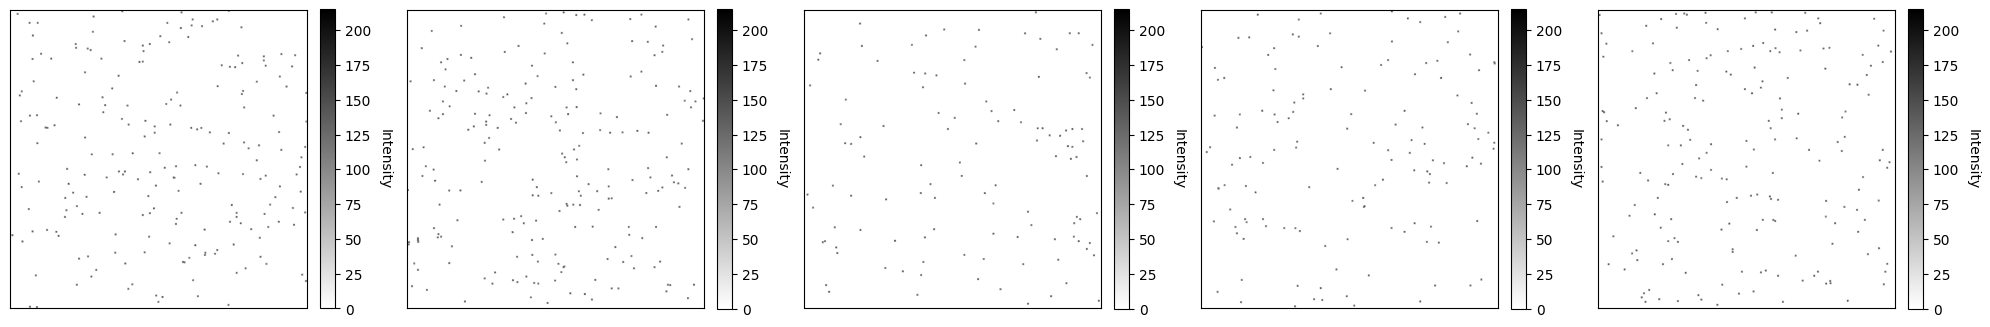

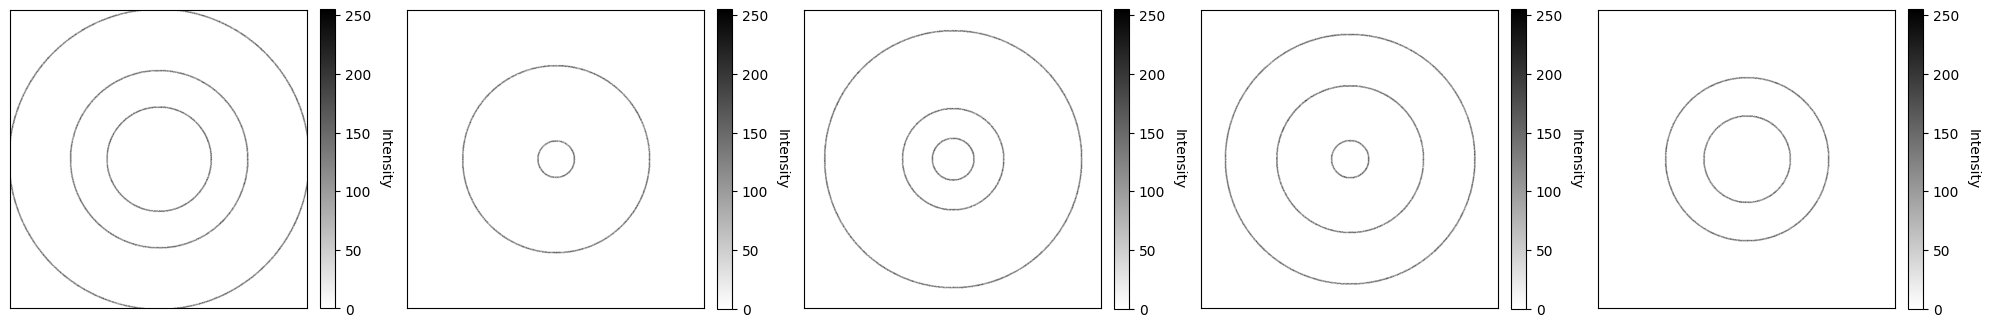

In [ ]:
# Visualize and save some of the separated images
Plot(dataset_dots, 5, None)
Plot(dataset_rings, 5, None)

In [ ]:
# Add radial background noise to the images
dataset_dots_noise = add_radial_noise(dataset_dots)
dataset_rings_noise = add_radial_noise(dataset_rings)
test_dataset_dots_noise = add_radial_noise(test_dataset_dots)
test_dataset_rings_noise = add_radial_noise(test_dataset_rings)

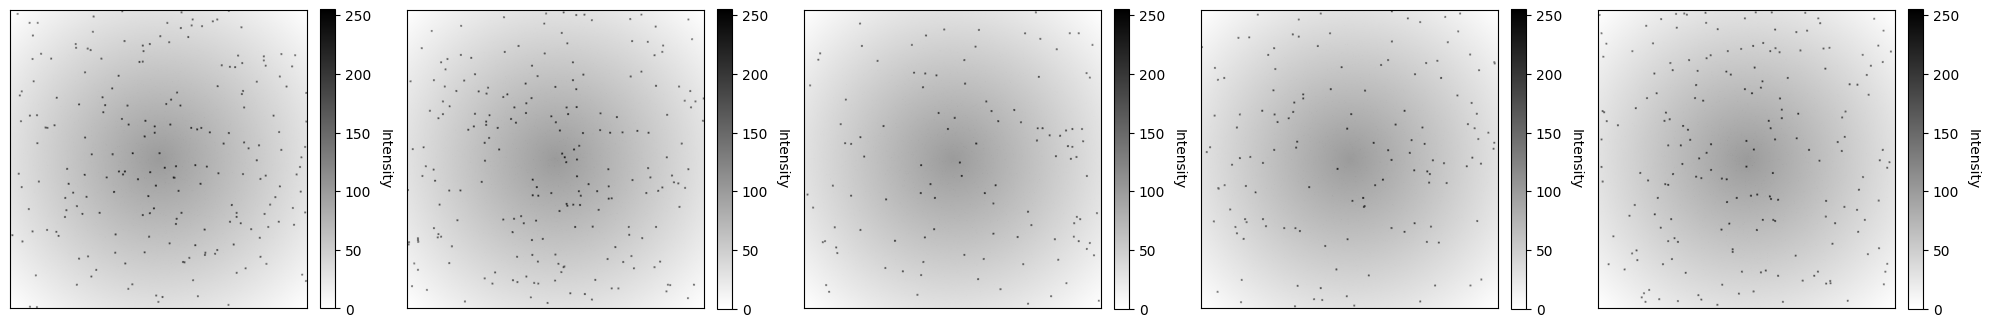

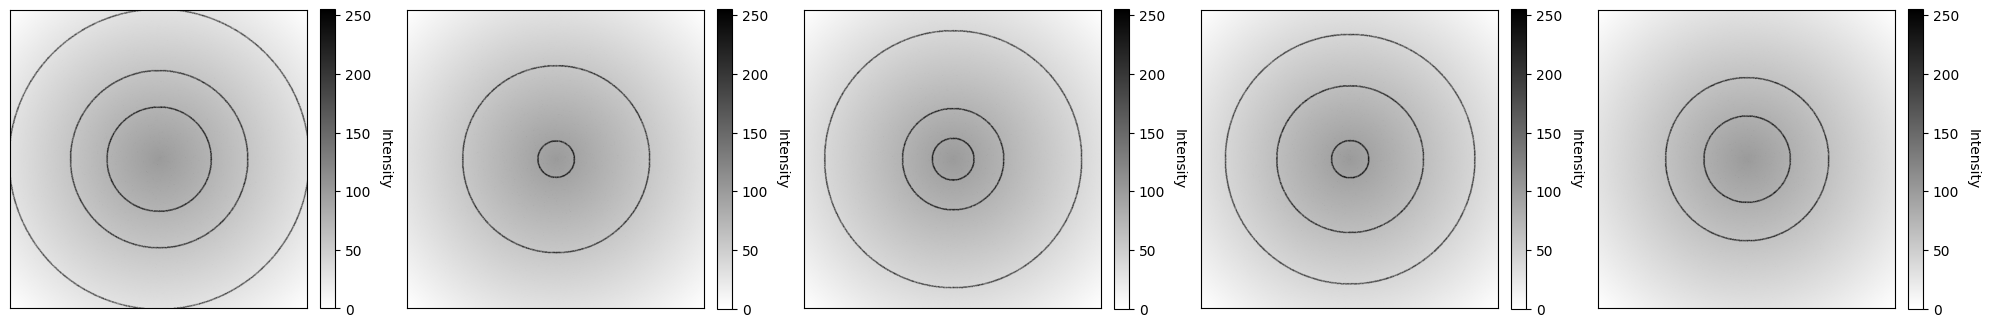

In [ ]:
# Visualize and save some of the separated images
Plot(dataset_dots_noise, 5, None)
Plot(dataset_rings_noise, 5, None)

x[0]: (800, 800): {'Mean': 92, 'Median': 88, 'Min': 1, '5th %': 30, '10th %': 40, '25th %': 62, '50th %': 88, '75th %': 120, '90th %': 150, '95th %': 168, 'Max': 255}
x[1]: (800, 800): {'Mean': 92, 'Median': 88, 'Min': 1, '5th %': 28, '10th %': 40, '25th %': 62, '50th %': 88, '75th %': 120, '90th %': 152, '95th %': 168, 'Max': 255}
x[2]: (800, 800): {'Mean': 95, 'Median': 90, 'Min': 1, '5th %': 28, '10th %': 40, '25th %': 62, '50th %': 90, '75th %': 126, '90th %': 158, '95th %': 178, 'Max': 255}
x[3]: (800, 800): {'Mean': 96, 'Median': 92, 'Min': 1, '5th %': 28, '10th %': 40, '25th %': 62, '50th %': 92, '75th %': 126, '90th %': 159, '95th %': 176, 'Max': 255}
x[4]: (800, 800): {'Mean': 93, 'Median': 88, 'Min': 1, '5th %': 28, '10th %': 40, '25th %': 60, '50th %': 88, '75th %': 126, '90th %': 158, '95th %': 177, 'Max': 255}


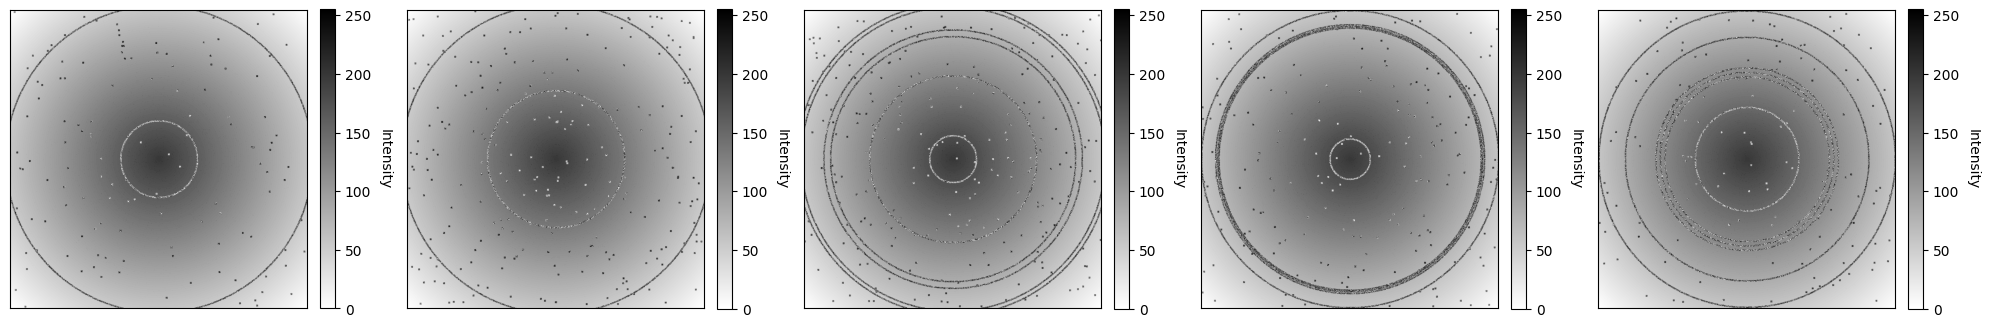

In [ ]:
# Combine images (use averaging or weighted sum)
# dataset_combined_weighted_sum = (dataset_dots_noise + dataset_rings_noise)
# test_images_combined_weighted_sum = (test_dataset_dots_noise + test_dataset_rings_noise)
# Plot(dataset_combined_weighted_sum, 5, None)

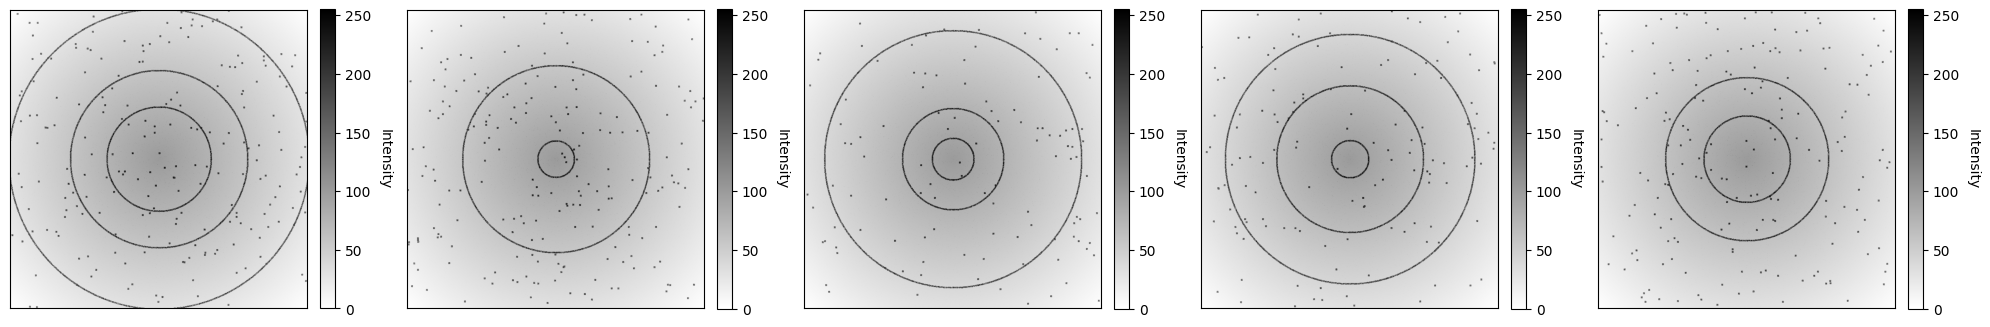

In [ ]:
# Combine images (use max pooling)
dataset_combined_max_pooling = np.maximum(dataset_dots_noise, dataset_rings_noise)
test_dataset_combined_max_pooling = np.maximum(test_dataset_dots_noise, test_dataset_rings_noise)
Plot(dataset_combined_max_pooling, 5, None)

In [ ]:
# Normalize images
dataset_rings_normalized = dataset_rings_noise.astype(np.float16) / 255.0
dataset_dots_normalized = dataset_dots_noise.astype(np.float16) / 255.0
test_dataset_rings_normalized = test_dataset_rings_noise.astype(np.float16) / 255.0
test_dataset_dots_normalized = test_dataset_dots_noise.astype(np.float16) / 255.0
dataset_rings_normalized_clean = dataset_rings.astype(np.float16) / 255.0
dataset_dots_normalized_clean = dataset_dots.astype(np.float16) / 255.0
test_dataset_rings_normalized_clean = test_dataset_rings.astype(np.float16) / 255.0
test_dataset_dots_normalized_clean = test_dataset_dots.astype(np.float16) / 255.0
dataset_combined_max_pooling_normalized = dataset_combined_max_pooling.astype(np.float16) / 255.0
test_dataset_combined_max_pooling_normalized = test_dataset_combined_max_pooling.astype(np.float16) / 255.0

In [ ]:
del dataset_dots, dataset_rings, test_dataset_dots, test_dataset_rings, dataset_rings_noise, dataset_dots_noise, test_dataset_rings_noise, test_dataset_dots_noise

# Manually invoke garbage collector
gc.collect()

55076

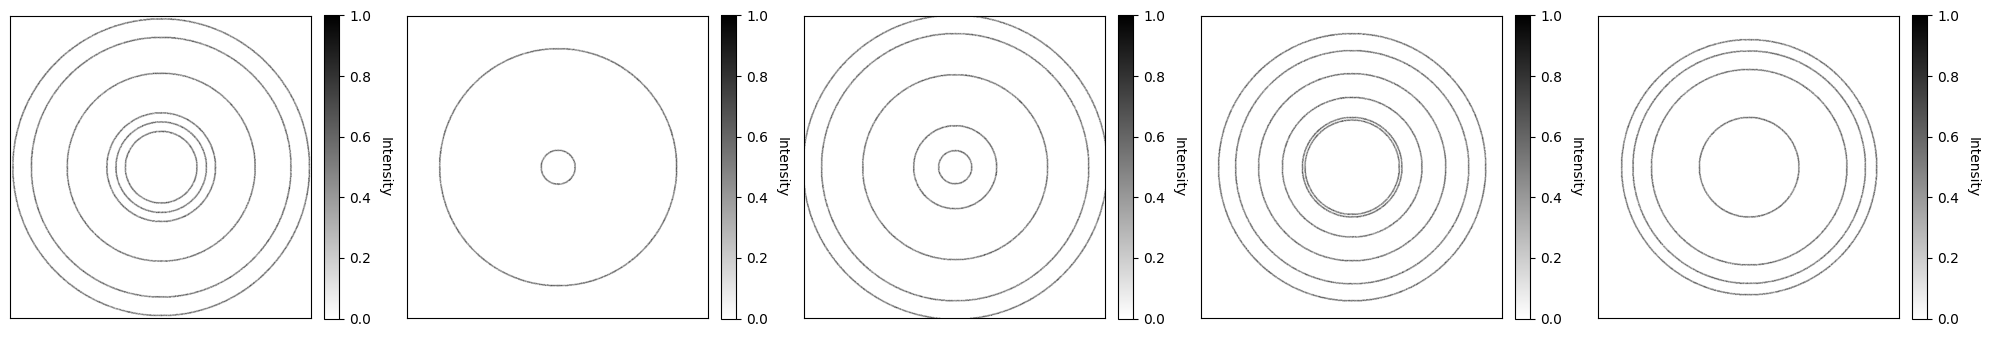

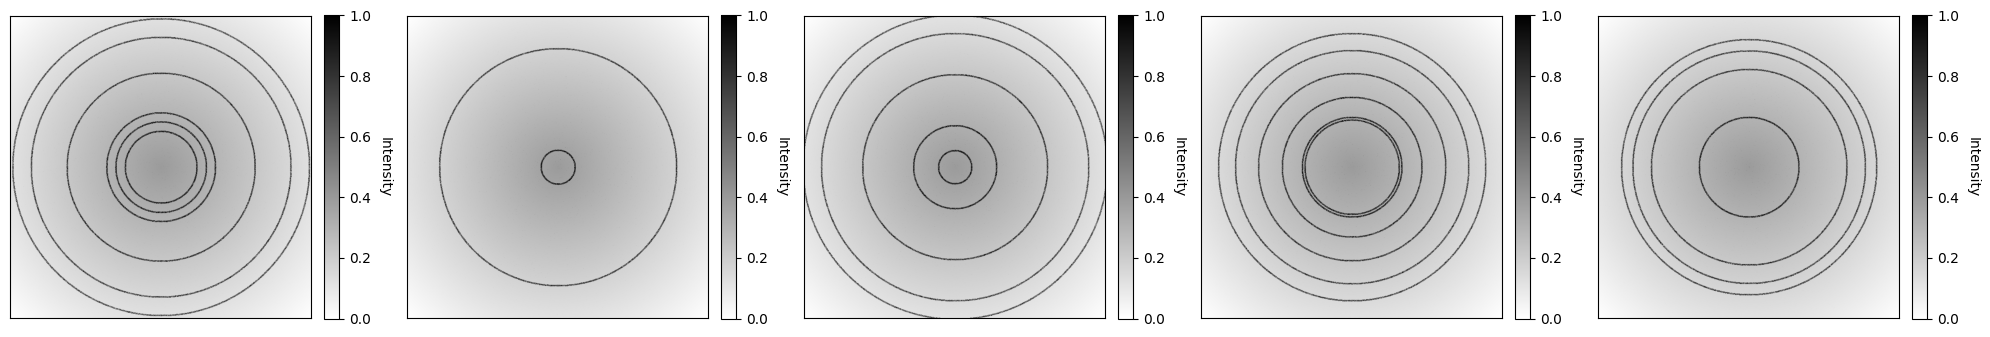

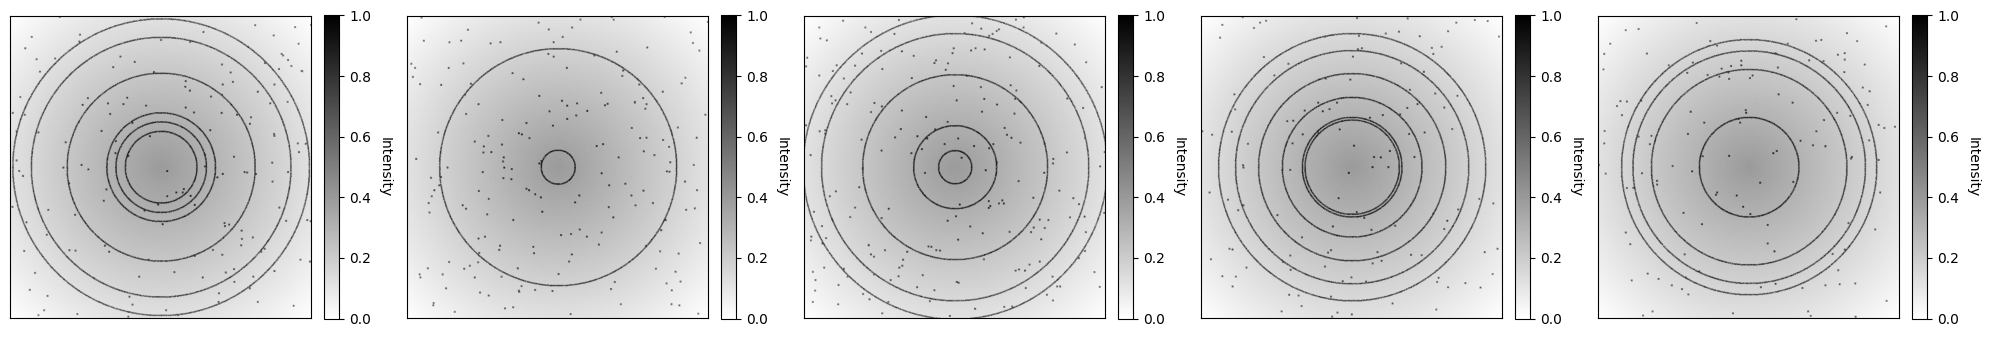

In [ ]:
Plot(test_dataset_rings_normalized_clean, 5, None)
Plot(test_dataset_rings_normalized, 5, None)
Plot(test_dataset_combined_max_pooling_normalized, 5, None)

In [ ]:
input_img = Input(shape=(height, width, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

autoencoder.fit(dataset_combined_max_pooling_normalized.reshape((-1, height, width, 1)),
                # dataset_rings_normalized.reshape((-1, height, width, 1)), # ouput data without noise (rings)
                dataset_rings_normalized_clean.reshape((-1, height, width, 1)), # ouput data without noise (rings)
                epochs=35, # 50
                batch_size=10, # 32
                validation_data = (test_dataset_combined_max_pooling_normalized.reshape((-1, height, width, 1)),
                                   # test_dataset_rings_normalized.reshape((-1, height, width, 1)))
                                   test_dataset_rings_normalized_clean.reshape((-1, height, width, 1))),
                callbacks=[early_stopping])

Epoch 1/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.1686 - val_loss: 0.0105
Epoch 2/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0102 - val_loss: 0.0105
Epoch 3/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 4/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0102 - val_loss: 0.0105
Epoch 5/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 6/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0101 - val_loss: 0.0105
Epoch 7/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 8/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 9/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0102 - val_loss: 0.0105
Epoch 10/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0099 - val_loss: 0.0105
Epoch 11/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0099 - val_loss: 0.0105
Epoch 12/35
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/ste

In [ ]:
# Use the trained autoencoder to decode the combined images
evaluation = autoencoder.evaluate(test_dataset_combined_max_pooling_normalized.reshape((-1, height, width, 1)), test_dataset_rings_normalized_clean.reshape((-1, height, width, 1)))
print('Test Accuracy : {:.3f}'.format(evaluation))

# reconstruct the image without dots and only rings
predicted = autoencoder.predict(test_dataset_combined_max_pooling_normalized.reshape((-1, height, width, 1)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0110
Test Accuracy : 0.010


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step


Autoencoder model input


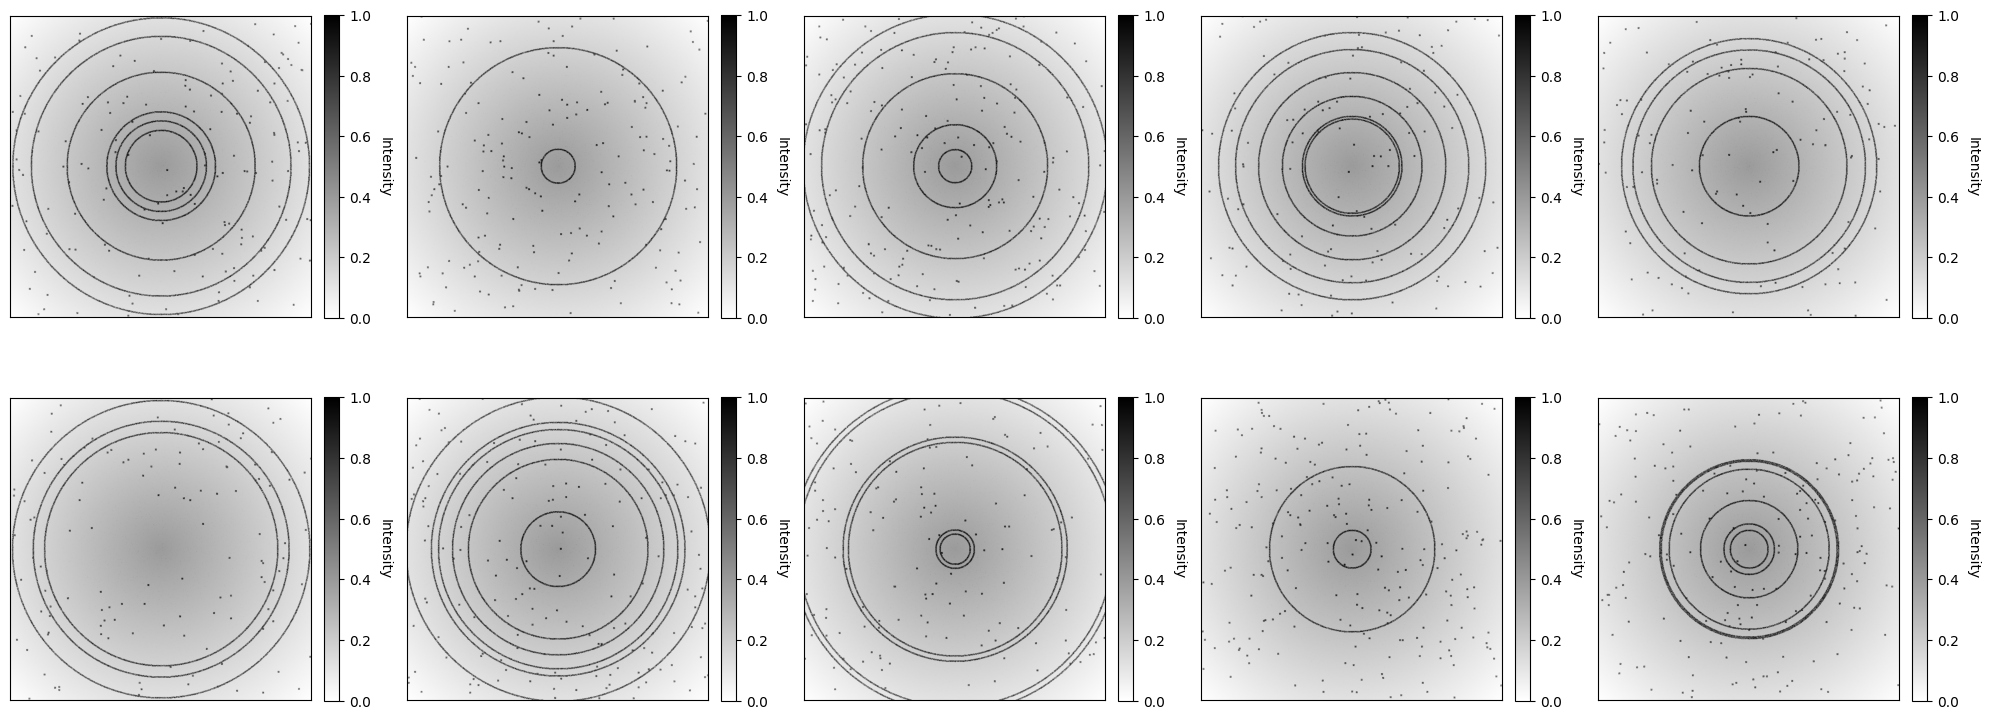

Autoencoder model output


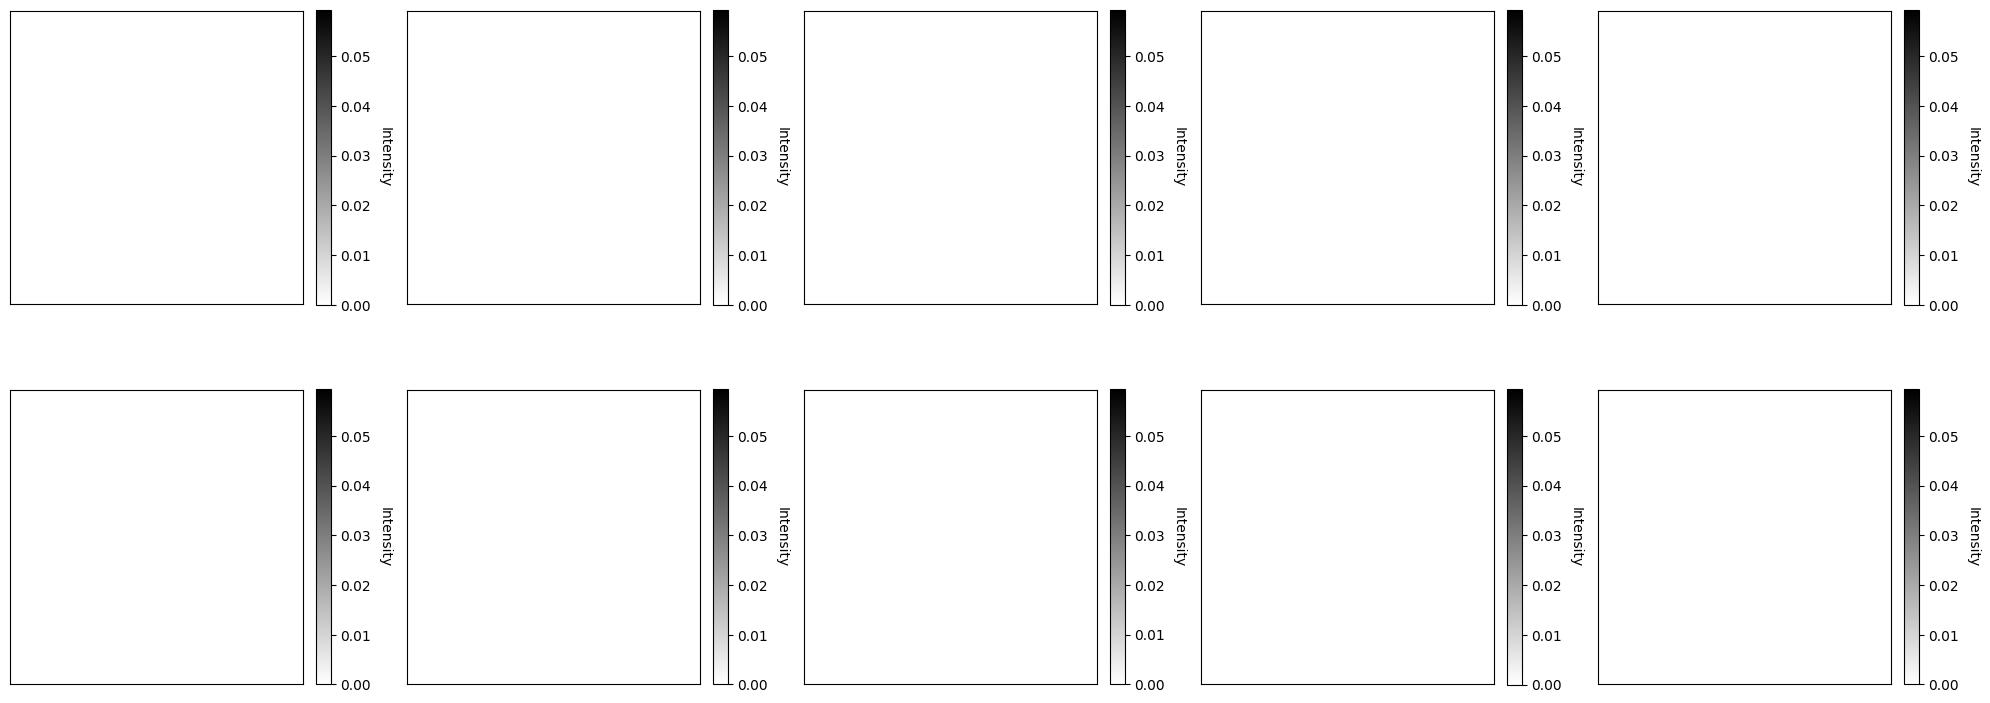

In [ ]:
# Visualize and save some of the separated images for 800x800 images
print("Autoencoder model input")
Plot(test_dataset_combined_max_pooling_normalized, 10, None)
print("Autoencoder model output")
Plot(predicted, 10, None)

test_dataset_combined_norm:  (200, 800, 800)
test_dataset_rings_normalized:  (200, 800, 800)
predicted:  (200, 800, 800, 1)
predicted_squeezed:  (200, 800, 800)
similar_pixels[0] [[False False False ... False False False]
 [False  True  True ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
dissimilar_mask[0] [[ True  True  True ...  True  True  True]
 [ True False False ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
test_dataset_dots_normalized[0] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
simulated_images_decoded[0] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 

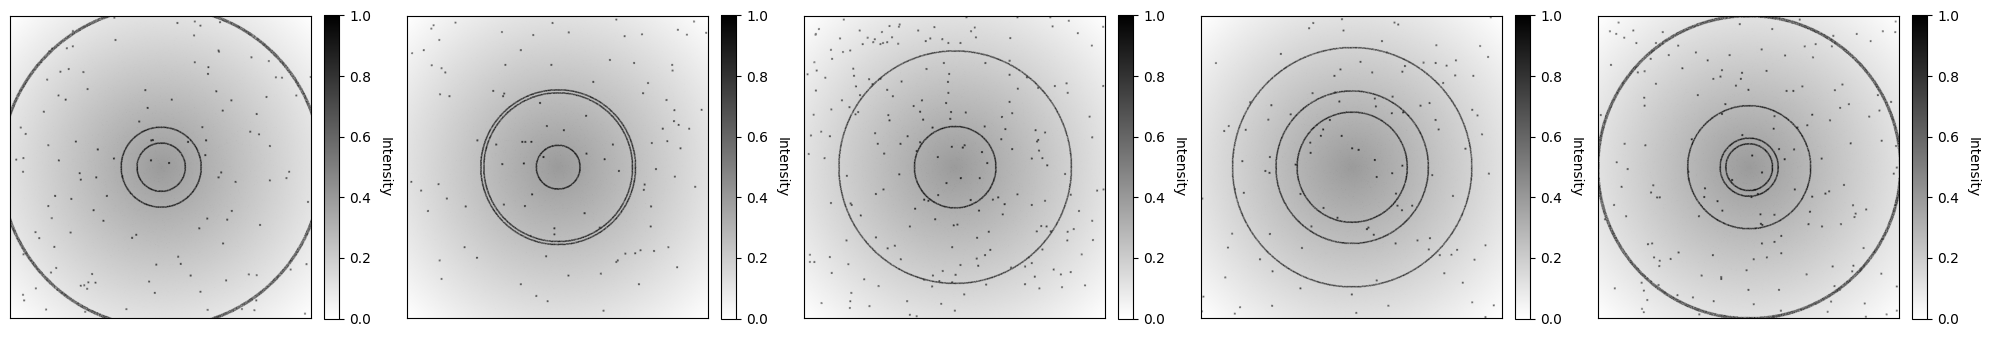

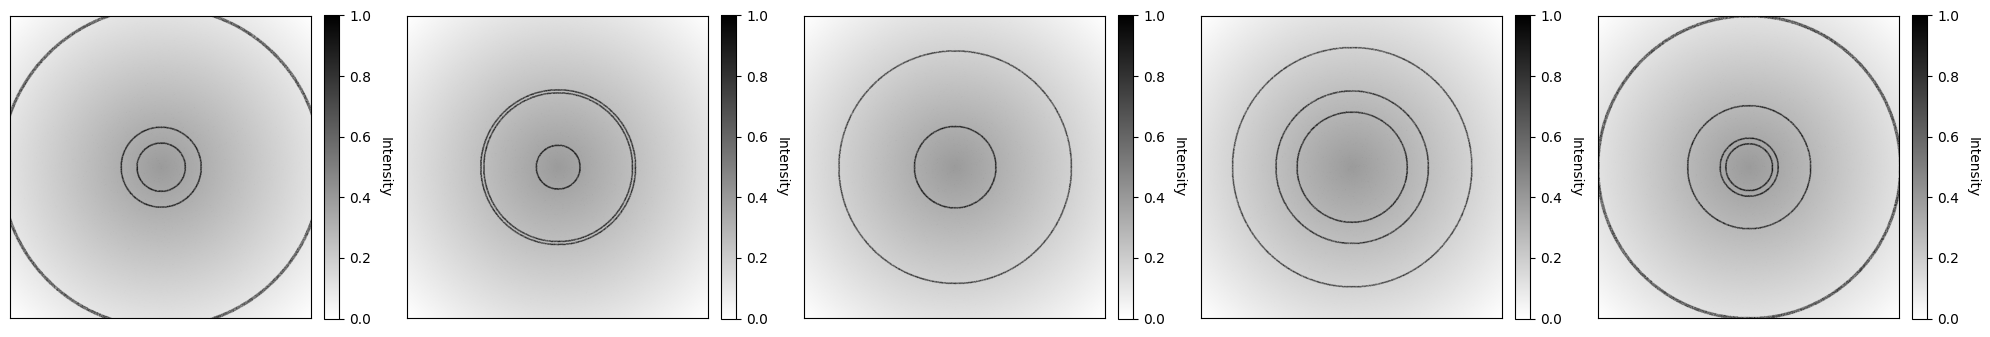

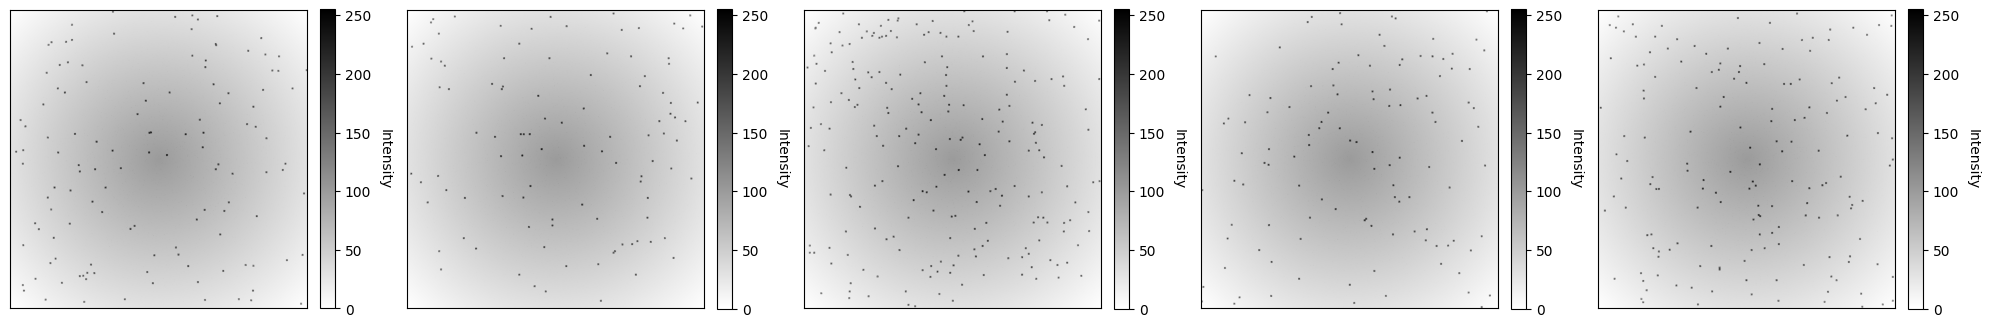

Autoencoder model ring onput + separate dots from combined images


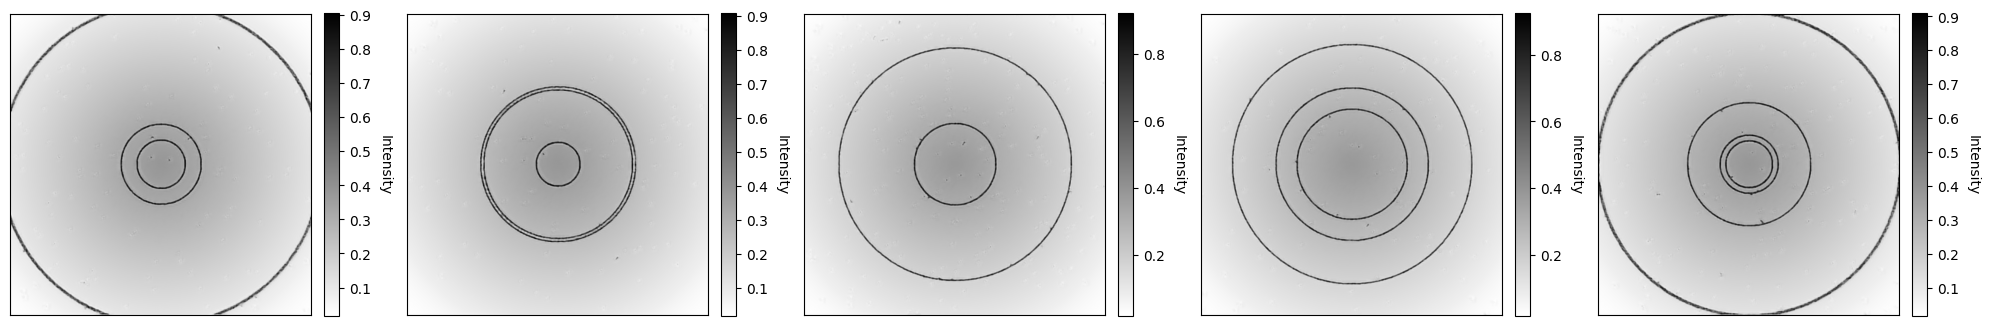

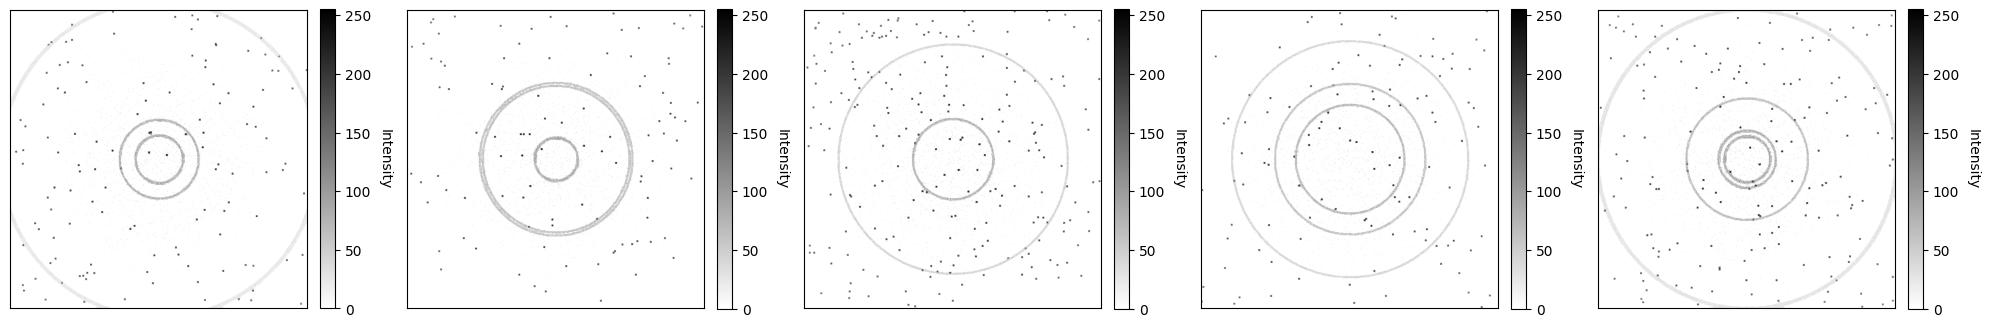

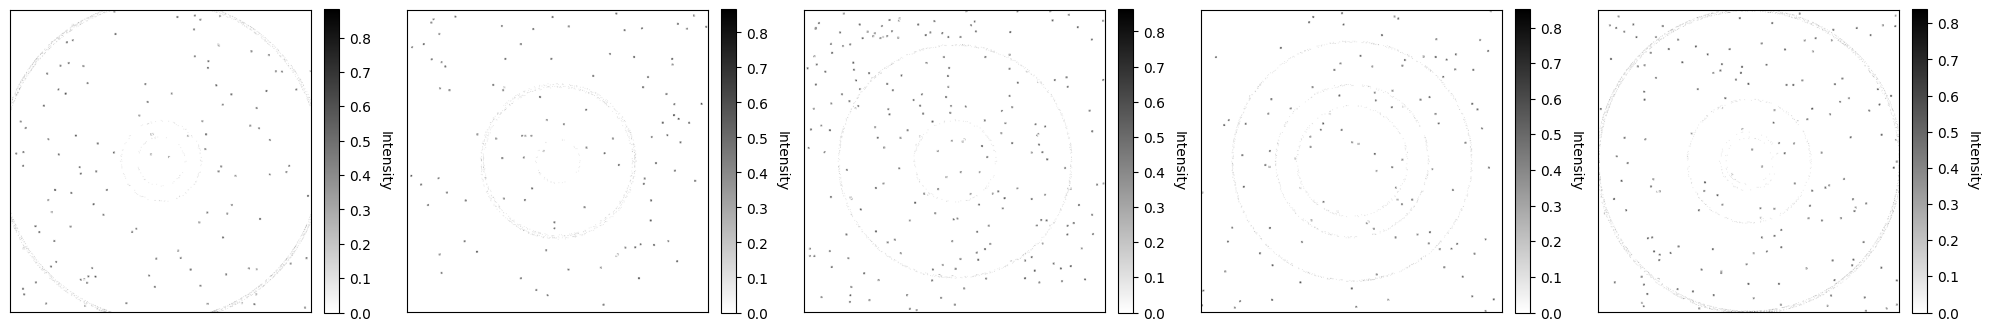

In [ ]:
# Separate the ring and dot images from the images_overaly for 800x800 images
print("test_dataset_combined_norm: ", test_dataset_combined_max_pooling_normalized.shape)
print("test_dataset_rings_normalized: ", test_dataset_rings_normalized_clean.shape)
print("predicted: ", predicted.shape) # shape (200, 800, 800, 1)
predicted_squeezed = np.squeeze(predicted)
print("predicted_squeezed: ", predicted_squeezed.shape)

# Separate the ring and dot images from the simulated test_dataset_combined_max_pooling_normalized
# Currently we have all black images with grey dots and grey rings (0 is black, 255 is white) or (0 is black, 1 is white)
# 0 is background, 255 is the lines..., (0 is background, 1 is the lines)

# Approach 1: When dissimilar_mask is TRUE dots pixel color is chosen, else background color is chosen
similar_pixels = np.isclose(test_dataset_combined_max_pooling_normalized, predicted_squeezed, atol=0.05)  # tolerance level 10% difference
dissimilar_mask = np.logical_not(similar_pixels)
# simulated_images_decoded = np.where(dissimilar_mask, test_dataset_dots_normalized, 1)
simulated_images_decoded = np.where(dissimilar_mask, test_dataset_dots_normalized, 0) # should use 0 for background for this case
# what about when the noise is high, dissimilar uses no noise test_dataset_dots_normalized, which will give it also 0 background...
print("similar_pixels[0]", similar_pixels[0])
print("dissimilar_mask[0]", dissimilar_mask[0])
test_dataset_dots_normalized = test_dataset_dots_normalized * 255
simulated_images_decoded = simulated_images_decoded * 255
print("test_dataset_dots_normalized[0]", test_dataset_dots_normalized[0])
print("simulated_images_decoded[0]", simulated_images_decoded[0])

# Approach 2: 1 - (ground truth - predicted)
difference = np.abs(test_dataset_combined_max_pooling_normalized - predicted_squeezed)
toleranced_difference = np.where(difference < 0.4, 0, difference) # tolerance level 10% difference
# simulated_images_decoded_alt = 1 - toleranced_difference
simulated_images_decoded_alt = toleranced_difference # should use 0 for background in this case

print(f"test_dataset_combined_max_pooling_normalized - max: {np.max(test_dataset_combined_max_pooling_normalized[0])} min: {np.min(test_dataset_combined_max_pooling_normalized[0])} non-zeros: {np.count_nonzero(test_dataset_combined_max_pooling_normalized[0])}")
print(f"predicted - max: {np.max(predicted_squeezed[0])} min: {np.min(predicted_squeezed[0])} non-zeros: {np.count_nonzero(predicted_squeezed[0])}")
print(f"simulated_images_decoded - max: {np.max(simulated_images_decoded[0])} min: {np.min(simulated_images_decoded[0])} non-zeros: {np.count_nonzero(simulated_images_decoded[0])}")
print(f"simulated_images_decoded_alt - max: {np.max(simulated_images_decoded_alt[0])} min: {np.min(simulated_images_decoded_alt[0])} non-zeros: {np.count_nonzero(simulated_images_decoded_alt[0])}")

print("Autoencoder model inputs")
Plot(test_dataset_combined_max_pooling_normalized, 5, None)
Plot(test_dataset_rings_normalized_clean, 5, None)
Plot(test_dataset_dots_normalized, 5, None)
print("Autoencoder model ring onput + separate dots from combined images")
Plot(predicted, 5, None)
Plot(simulated_images_decoded, 5, None)
Plot(simulated_images_decoded_alt, 5, None)

In [ ]:
def plot_rmsd_values(rmsd_values, title="RMSD Values per Image", save_path=None):
    """
    Plots RMSD values for a list of image comparisons.

    Parameters:
    - rmsd_values: list or array of RMSD values (length = number of image pairs)
    - title: title of the plot
    - save_path: if provided, saves the plot to this file path
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(rmsd_values) + 1), rmsd_values, marker='o', linestyle='-', color='blue')

    # Add reference lines
    plt.axhline(y=0.01, color='green', linestyle='--', label='RMSD = 0.01 (good match)')
    plt.axhline(y=0.05, color='red', linestyle='--', label='RMSD = 0.05 (noticeable difference)')

    plt.title(title)
    plt.xlabel("Image Index")
    plt.ylabel("RMSD")
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

In [ ]:
def plot_overlay_examples(overlay_images, num_examples=5, figsize=(15, 3), start_index=0):
    """
    Display a subset of overlay images for visual comparison.

    Parameters:
    - overlay_images: list or array of RGB overlay images (H, W, 3)
    - num_examples: number of images to display (default = 5)
    - figsize: size of the entire figure (default = (15, 3))
    - start_index: index to start selecting images from (default = 0)
    """
    end_index = min(start_index + num_examples, len(overlay_images))
    plt.figure(figsize=figsize)

    for i, idx in enumerate(range(start_index, end_index)):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(overlay_images[idx])
        plt.axis('off')
        plt.title(f"Image {idx+1}")

    plt.tight_layout()
    plt.show()

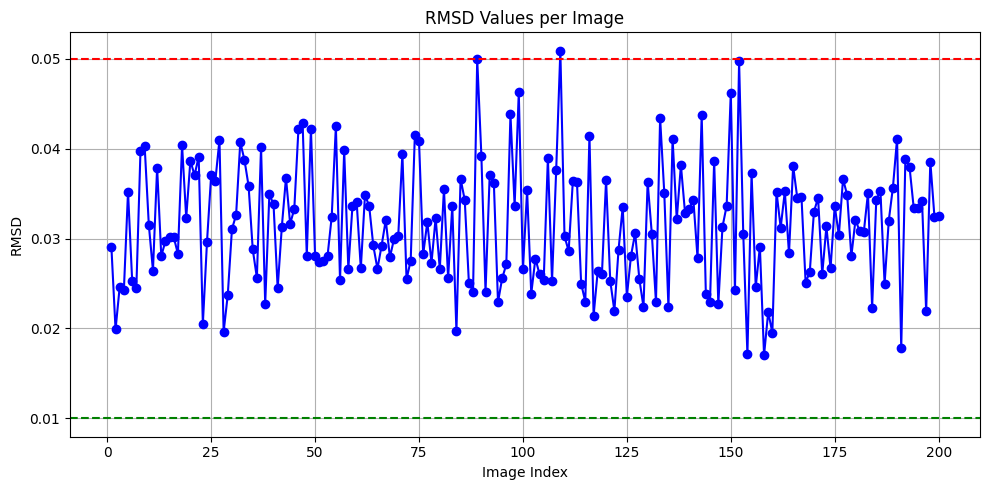

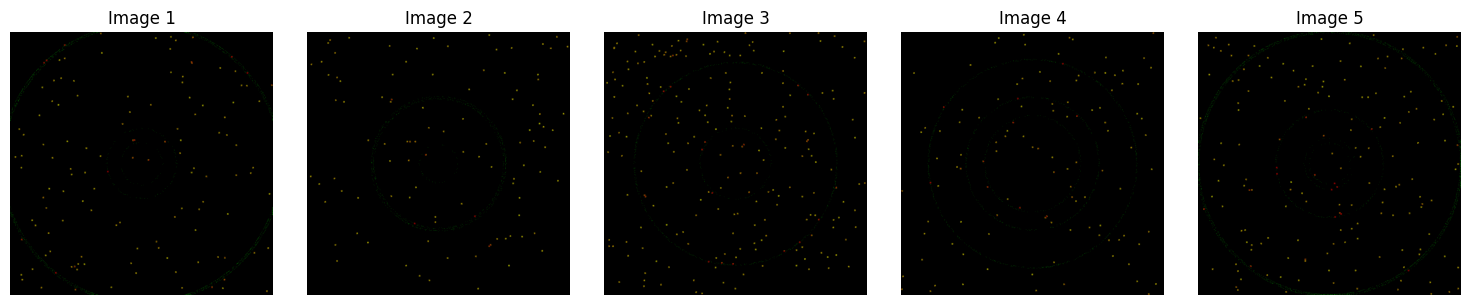

In [ ]:
# Run comparison
#rmsds, overlays = compare_autoencoder_output(test_dataset_dots_normalized, simulated_images_decoded_alt)
rmsds, overlays = compare_autoencoder_output(test_dataset_dots_normalized_clean, simulated_images_decoded_alt)

# Plot RMSD values
plot_rmsd_values(rmsds)

# Show 5 overlay images
plot_overlay_examples(overlays, num_examples=5)

Test Cases

* rings (255) and dots (40) with no noise - DONE (GOOD PERFORMANCE)
  * ring training (255) and test (255)
  * ring training (255) and test (40-215) - IS THIS NEEDED

* rings (40-215) and dots (40-215) with no noise - TODO
  * ring training (40-215) and test (40-215)

* rings (215) and dots (40) with uniform noise (0-40) - TODO
  * ring training (215) and test (215)
  * ring training (255) and test (40-215)

* rings (40-215) and dots (40-215) with uniform noise (0-40) - TODO
  * ring training (40-215) and test (40-215)

* rings (255) and dots (40) with radial noise (100-0) - TODO
  * ring training (255) and test (255)
  * ring training (255) and test (40-215)

* rings (255) and dots (40-215) with radial noise (100-0)
  * ring training (255) and test (255) - DONE (captured)
  * ring training (255) and test (40-215)

* rings (40-215) and dots (40-215) with radial noise (100-0)
  * ring training (40-215) and test (40-215) - DONE (captured)

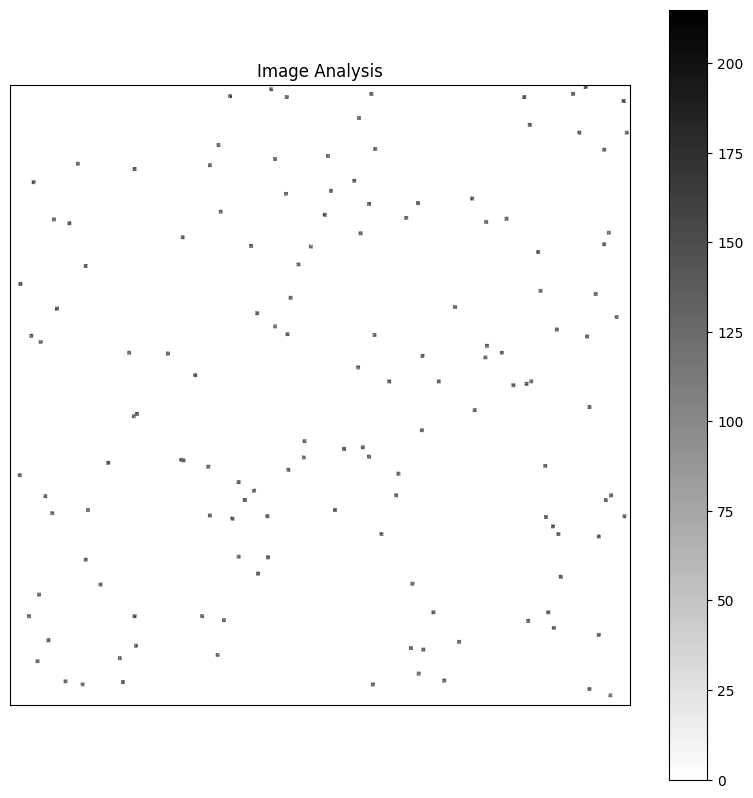

In [ ]:
plotLarge(dataset_dots[0])
# plotLarge(dataset_rings[0])

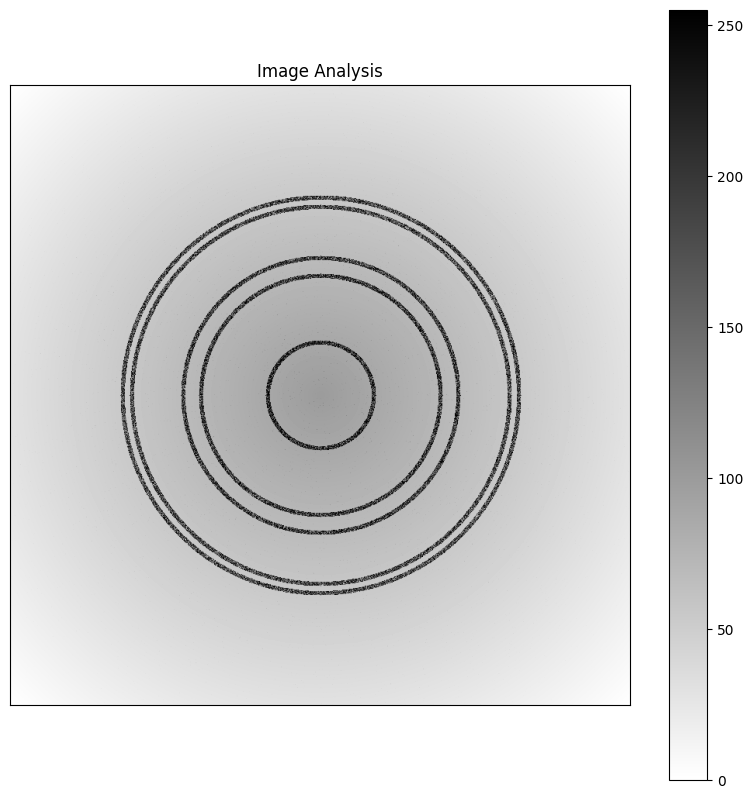

In [ ]:
# plotLarge(dataset_dots_noise[0])
plotLarge(dataset_rings_noise[0])

In [ ]:
# number_of_similar_pixels = np.count_nonzero(similar_pixels)
# similar_indices = np.where(similar_pixels)
# number_of_dissimilar_pixels = np.count_nonzero(dissimilar_mask)
# dissimilar_indices = np.where(dissimilar_mask)
# dissimilar_values_test = test_dataset_combined_norm[dissimilar_indices]
# dissimilar_values_predicted = predicted_squeezed[dissimilar_indices]
# print("Similarities between ground truth and autoencoder output")
# print("Number of similar pixels:", number_of_similar_pixels)
# print("Number of dissimilar pixels:", number_of_dissimilar_pixels)

# not_close_to_one = np.logical_not(np.isclose(test_dataset_combined_max_pooling_normalized[0], 1, atol=0.05))
# print(f"test_dataset_combined_norm - non-ones: {np.count_nonzero(not_close_to_one)}")
# not_close_to_one = np.logical_not(np.isclose(predicted_squeezed[0], 1, atol=0.05))
# print(f"predicted_squeezed - non-ones: {np.count_nonzero(not_close_to_one)}")
# not_close_to_one = np.logical_not(np.isclose(simulated_images_decoded[0], 1, atol=0.05))
# print(f"simulated_images_decoded - non-ones: {np.count_nonzero(not_close_to_one)}")
# not_close_to_one = np.logical_not(np.isclose(simulated_images_decoded_alt[0], 1, atol=0.05))
# print(f"simulated_images_decoded_alt - non-ones: {np.count_nonzero(not_close_to_one)}")